this experiment use z multiple c as the only input to decoder


In [1]:
import os
os.chdir("../")

# Set R environment variables using the conda environment path
r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
os.environ['R_HOME'] = r_home
os.environ['R_LIBS'] = f"{r_home}/library"
os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital2d_simple1_zc import *
print("using device: ", device)

Random seed set to 333
using device:  cuda


## Customize Configuration

In [3]:
# (customize) configs
overwrite = True
model_name = 'test_succ_inc_simple5' 
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col = 'description_succ_inc',#'ts_description',
    y_col = 'description_succ_inc',
    y_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    y_pred_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    txt2ts_y_cols = ['description_succ_inc'],
    custom_target_cols = ['description_succ_inc', 'label'], # 'label' is the same as the default "by_label" target
    downsample = True,
    downsample_size = 5000,
    downsample_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    model_name = model_name,
    embedded_dim = 256,
    batch_size = 512, # Data loader settings
    patience = 100, # Training settings
    num_saves = 10,
    num_epochs = 10,
    init_lr = 5e-5,
    text_config = text_config,
    **{'3d': False}  # Add this line
)
config_dict = get_config_dict()


#  result saving directory
output_dir = './results/'+config_dict['model_name']
model_clip_path = output_dir+'/model_clip.pth' 
eval_clip_path = output_dir+'/evals_clip.pth'
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'

In [4]:
# ----- ready dataframe ------
overwrite_org = overwrite
overwrite = False

# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())

overwrite = overwrite_org


# ------------------------- augment simple patterns to time series -------------------------
df_train = add_linear_trend(df_train, slope=0.2, text_condition="High amount of consecutive increases.")
df_train = add_linear_trend(df_train, slope=-0.2, text_condition="Low amount of consecutive increases.")

df_test = add_linear_trend(df_test, slope=0.2, text_condition="High amount of consecutive increases.")
df_test = add_linear_trend(df_test, slope=-0.2, text_condition="Low amount of consecutive increases.")


# ------------------------- ready eval inputs for CLIP -------------------------
if overwrite or not os.path.exists(model_path):
    # ------------------------- ready eval inputs for CLIP -------------------------
    # 1. ts to txt prediction evaluation (truei and texti are reserved names) 
    n_levels = len(config_dict['y_levels'])
    for i in range(n_levels):
        df_train[f'true{i+1}'] = df_train[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
        df_train[f'text{i+1}'] = config_dict['y_pred_levels'][i]
    for i in range(n_levels):
        df_test[f'true{i+1}'] = df_test[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
        df_test[f'text{i+1}'] = config_dict['y_pred_levels'][i]
    evalclipts2txt_train = EvalCLIPTS2TXT(df_train, 
                                            config_dict,
                                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                                            y_pred_cols_ls = config_dict['y_pred_cols_ls'])
    evalclipts2txt_test = EvalCLIPTS2TXT(df_test, 
                                            config_dict,
                                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                                            y_pred_cols_ls = config_dict['y_pred_cols_ls'])
    # 2. txt to ts prediction evaluation (caption is reserved name)
    txt_tsid_mapping_train = []
    for col in config_dict['txt2ts_y_cols']:  
        txt_tsid_mapping_train_sub = gen_txt_tsid_mapping(df_train, col, k=500, n_neg=3)
        txt_tsid_mapping_train.extend(txt_tsid_mapping_train_sub)
    txt_tsid_mapping_test = []
    for col in config_dict['txt2ts_y_cols']: 
        txt_tsid_mapping_test_sub = gen_txt_tsid_mapping(df_test, col, k=500, n_neg=3)
        txt_tsid_mapping_test.extend(txt_tsid_mapping_test_sub)
    evalcliptxt2ts_train = EvalCLIPTXT2TS(df_train, txt_tsid_mapping_train, config_dict)
    evalcliptxt2ts_test = EvalCLIPTXT2TS(df_test, txt_tsid_mapping_test, config_dict)

    # ------------------------- ready dataloaders ------------------------- 
    if config_dict['3d']:
        ts_f_train, tx_f_train_ls, labels_train = get_features3d(df_train, 
                                                                config_dict,
                                                                text_col_ls = config_dict['text_col_ls'])
        train_dataloader = VITAL3DDataset(ts_f_train, tx_f_train_ls, labels_train, target_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test_ls, labels_test = get_features3d(df_test, 
                                                                config_dict,
                                                                text_col_ls = config_dict['text_col_ls'])
        test_dataloader = VITAL3DDataset(ts_f_test, tx_f_test_ls, labels_test, target_test).dataloader(batch_size=config_dict['batch_size'])
    else: 
        ts_f_train, tx_f_train, labels_train = get_features(df_train,
                                                            config_dict)
        train_dataloader = VITALDataset(ts_f_train, tx_f_train, labels_train, target_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test, labels_test = get_features(df_test,
                                                            config_dict)
        test_dataloader = VITALDataset(ts_f_test, tx_f_test, labels_test, target_test).dataloader(batch_size=config_dict['batch_size'])



Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=72)]: Done 391 tasks      | elapsed:    3.9s
[Parallel(n_jobs=72)]: Done 2212 tasks      | elapsed:    5.0s
[Parallel(n_jobs=72)]: Done 8480 tasks      | elapsed:    8.8s
[Parallel(n_jobs=72)]: Done 17280 tasks      | elapsed:   12.1s
[Parallel(n_jobs=72)]: Done 27680 tasks      | elapsed:   14.5s
[Parallel(n_jobs=72)]: Done 39680 tasks      | elapsed:   17.0s
[Parallel(n_jobs=72)]: Done 53280 tasks      | elapsed:   19.9s
[Parallel(n_jobs=72)]: Done 64760 tasks      | elapsed:   22.4s
[Parallel(n_jobs=72)]: Done 65100 out of 65100 | elapsed:   22.6s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    42910
Low amount of consecutive increases.         11838
High amount of consecutive increases.        10352
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=72)]: Done 504 tasks      | elapsed:    0.3s
[Parallel(n_jobs=72)]: Done 3440 tasks      | elapsed:    1.0s
[Parallel(n_jobs=72)]: Done 16816 tasks      | elapsed:    3.8s
[Parallel(n_jobs=72)]: Done 34416 tasks      | elapsed:    7.4s
[Parallel(n_jobs=72)]: Done 55216 tasks      | elapsed:   11.5s
[Parallel(n_jobs=72)]: Done 60368 tasks      | elapsed:   12.5s
[Parallel(n_jobs=72)]: Done 61197 out of 61197 | elapsed:   13.0s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    36173
Low amount of consecutive increases.         13165
High amount of consecutive increases.        11859
Name: count, dtype: int64
After downsampling:
description_succ_inc
High amount of consecutive increases.    5000
Low amount of consecutive increases.     5000
Name: count, dtype: int64
After downsampling:
description_succ_inc
High amount of consecutive increases.    5000
Low amount of consecutive increases.     5000
Name: count, dtype: int64


final distribution of text prediction
description_succ_inc
High amount of consecutive increases.    5000
Low amount of consecutive increases.     5000
Name: count, dtype: int64
description_succ_inc
High amount of consecutive increases.    5000
Low amount of consecutive increases.     5000
Name: count, dtype: int64


/home/jq2uw/.local/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### Customize VITAL Model

In [5]:
# overwrite = False
# customize model
if overwrite or not os.path.exists(model_path):    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = False
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = False
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    

    
    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path, map_location=torch.device(device))
    model = config_dict['model_init']
    print(nn_summary(model))
    model.device = device

    

Layer (type:depth-idx)                                            Param #
VITAL                                                             1
├─TSVAEEncoder: 1-1                                               --
│    └─LocalNorm: 2-1                                             --
│    └─Sequential: 2-2                                            --
│    │    └─MultiLSTMEncoder: 3-1                                 11,111,424
│    │    └─LayerNorm: 3-2                                        512
│    │    └─Linear: 3-3                                           131,584
│    │    └─LeakyReLU: 3-4                                        --
│    │    └─LayerNorm: 3-5                                        1,024
│    │    └─Linear: 3-6                                           131,328
│    │    └─LeakyReLU: 3-7                                        --
│    │    └─LayerNorm: 3-8                                        512
│    └─Linear: 2-3                                                65,792
│  

# train jointly 

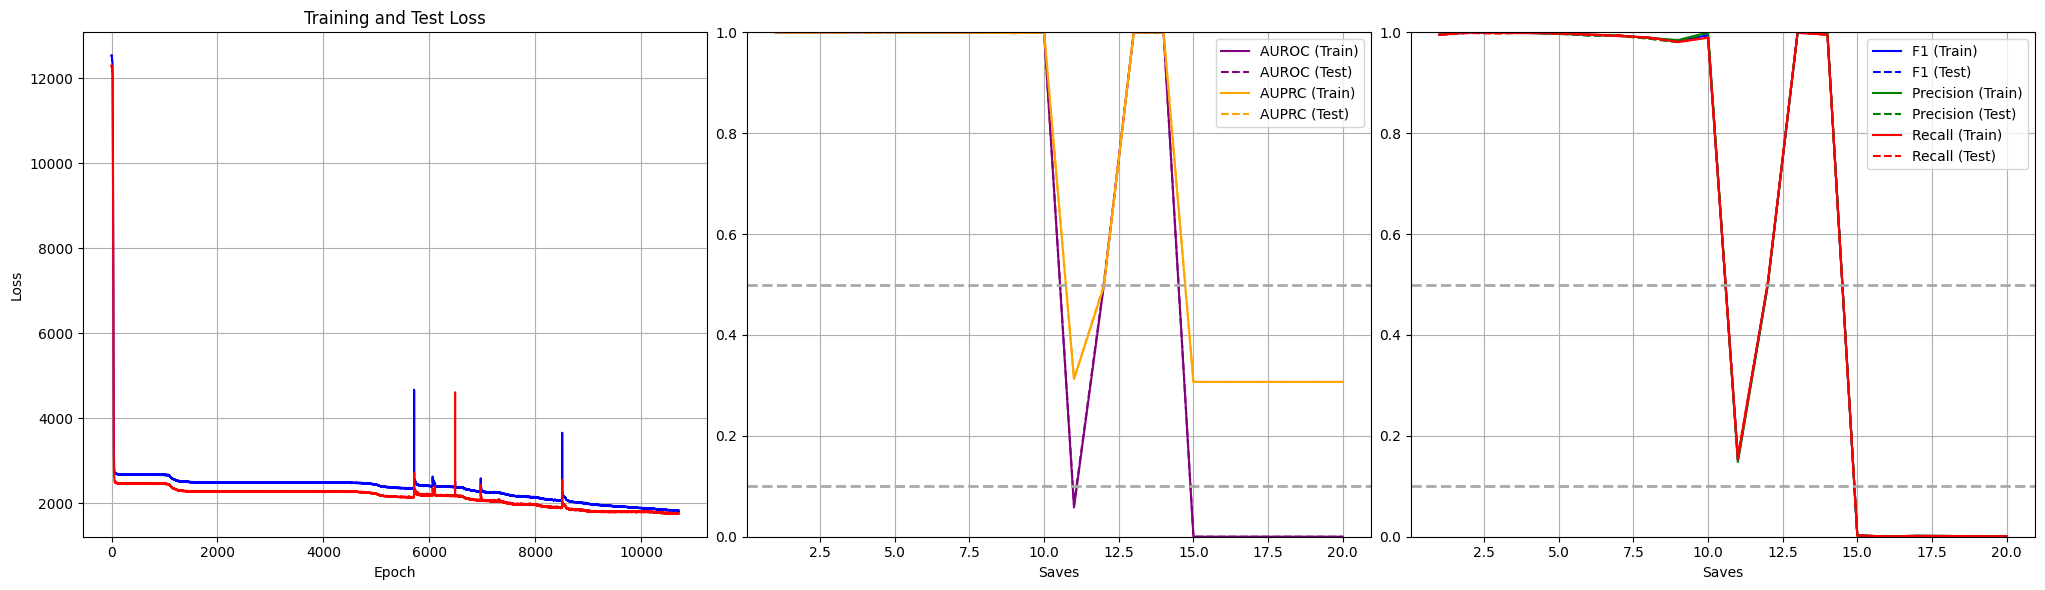

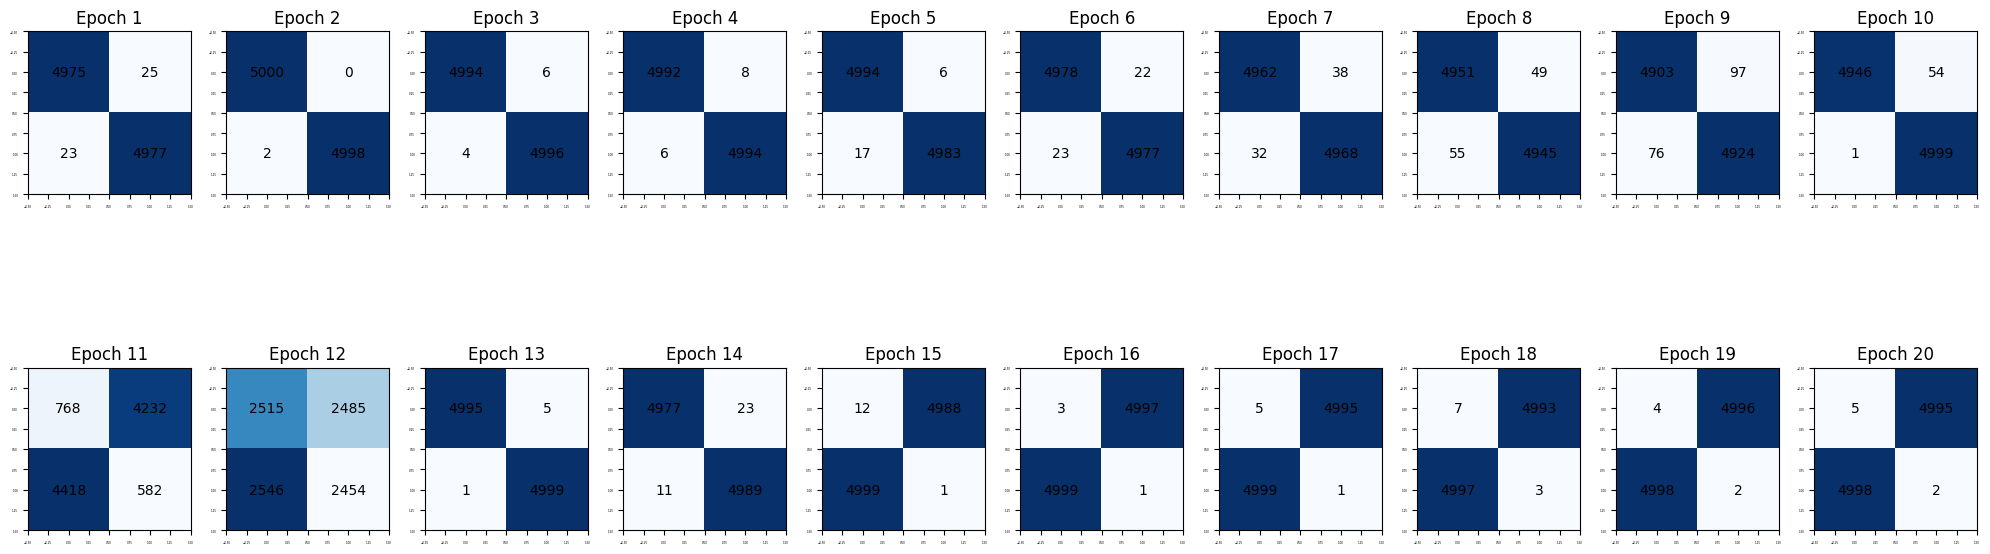

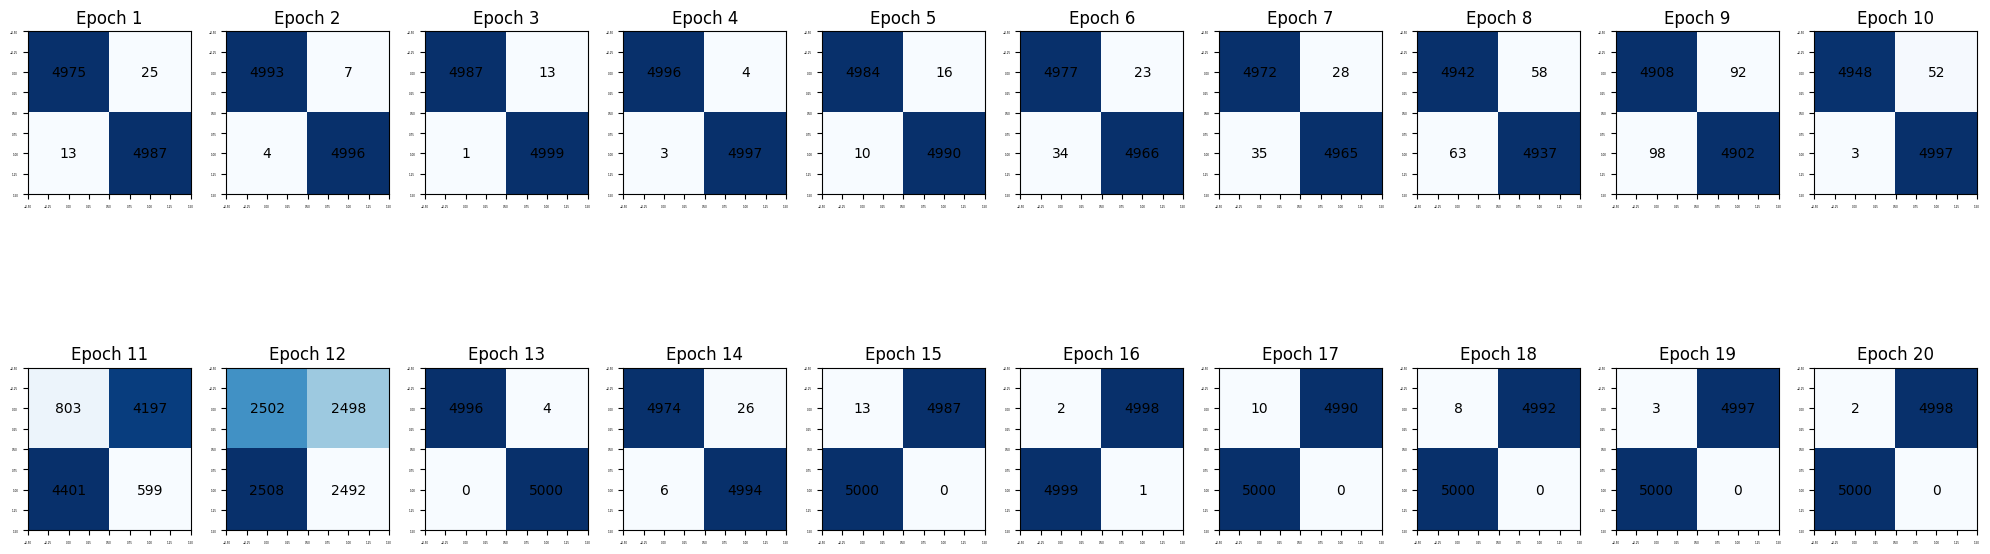

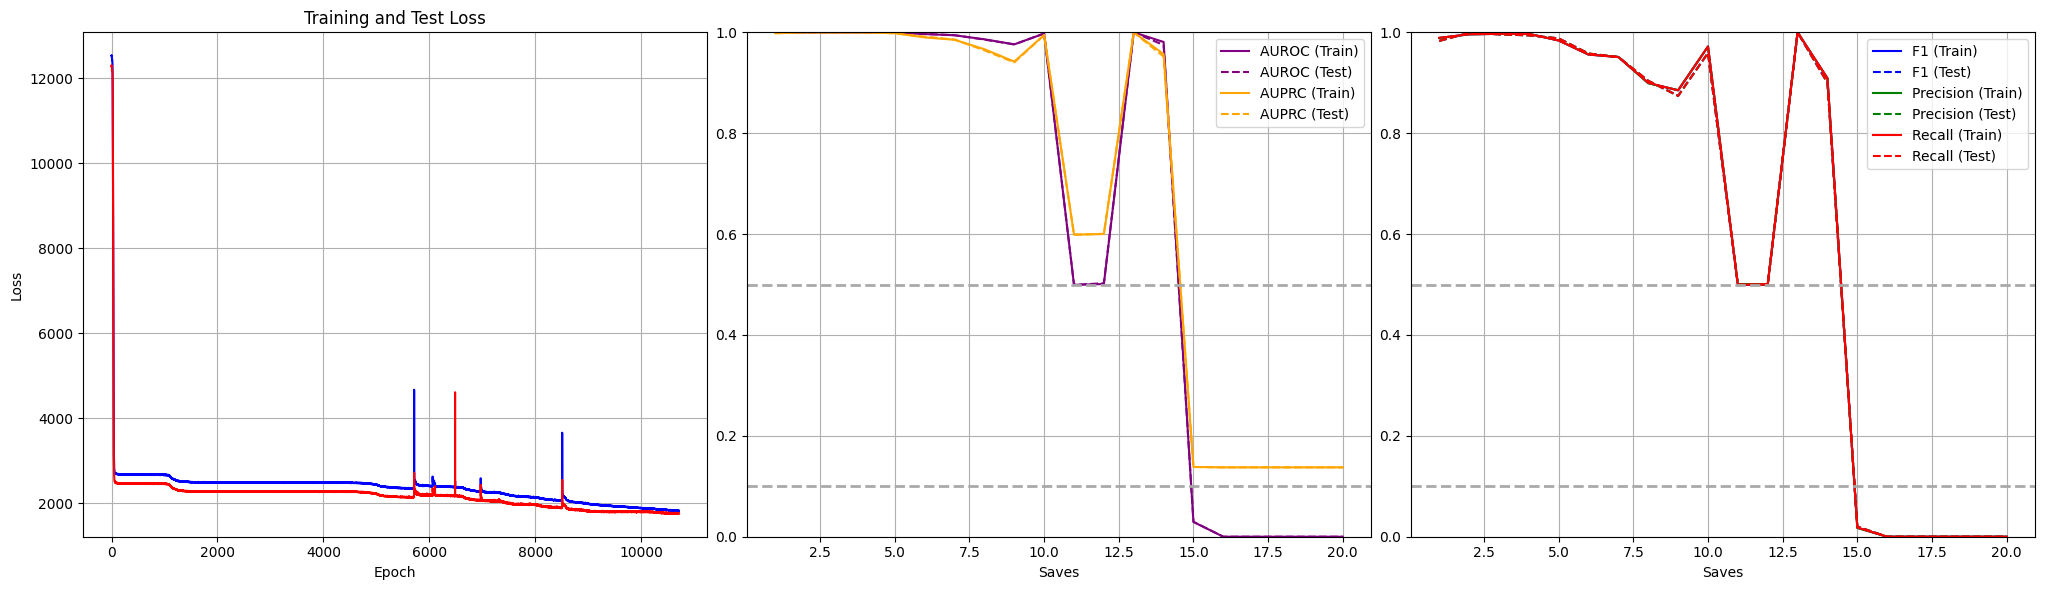

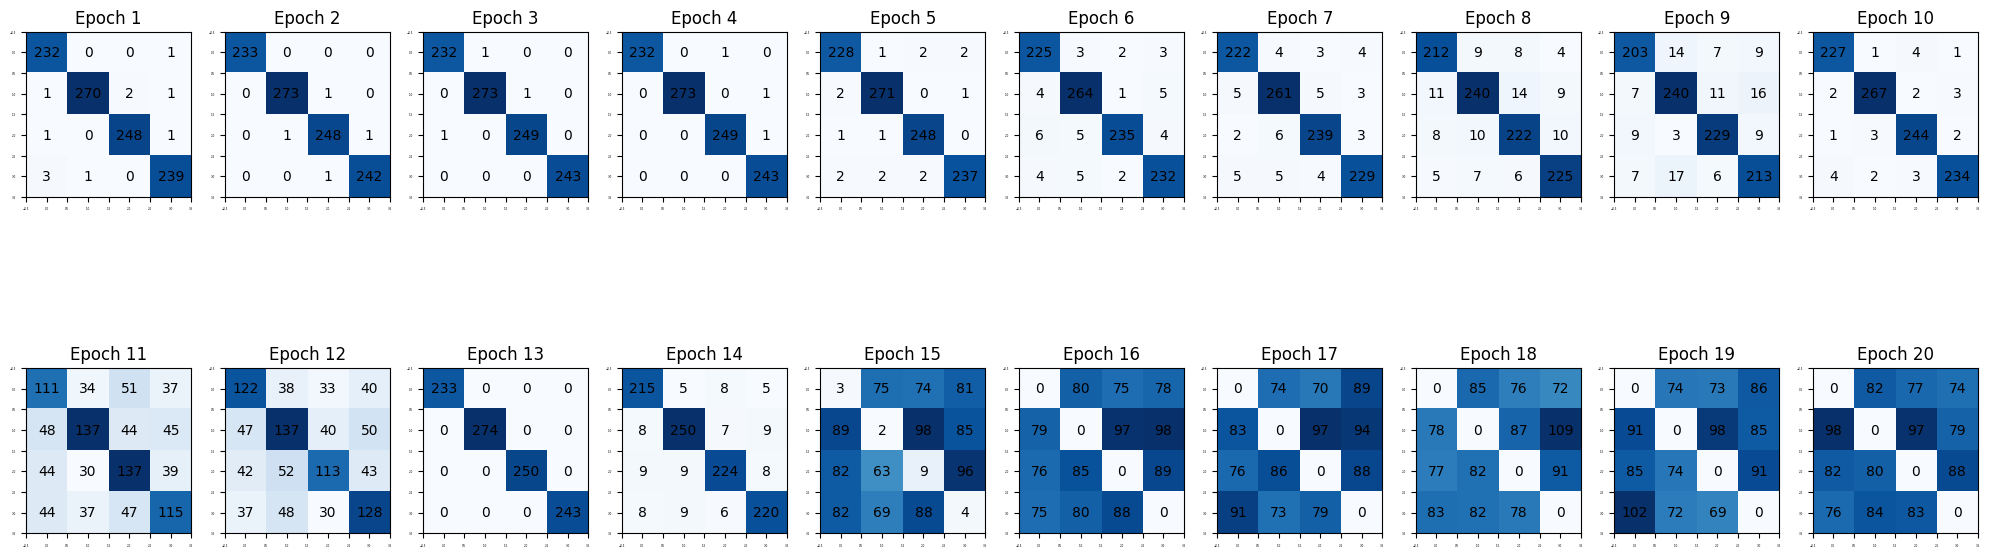

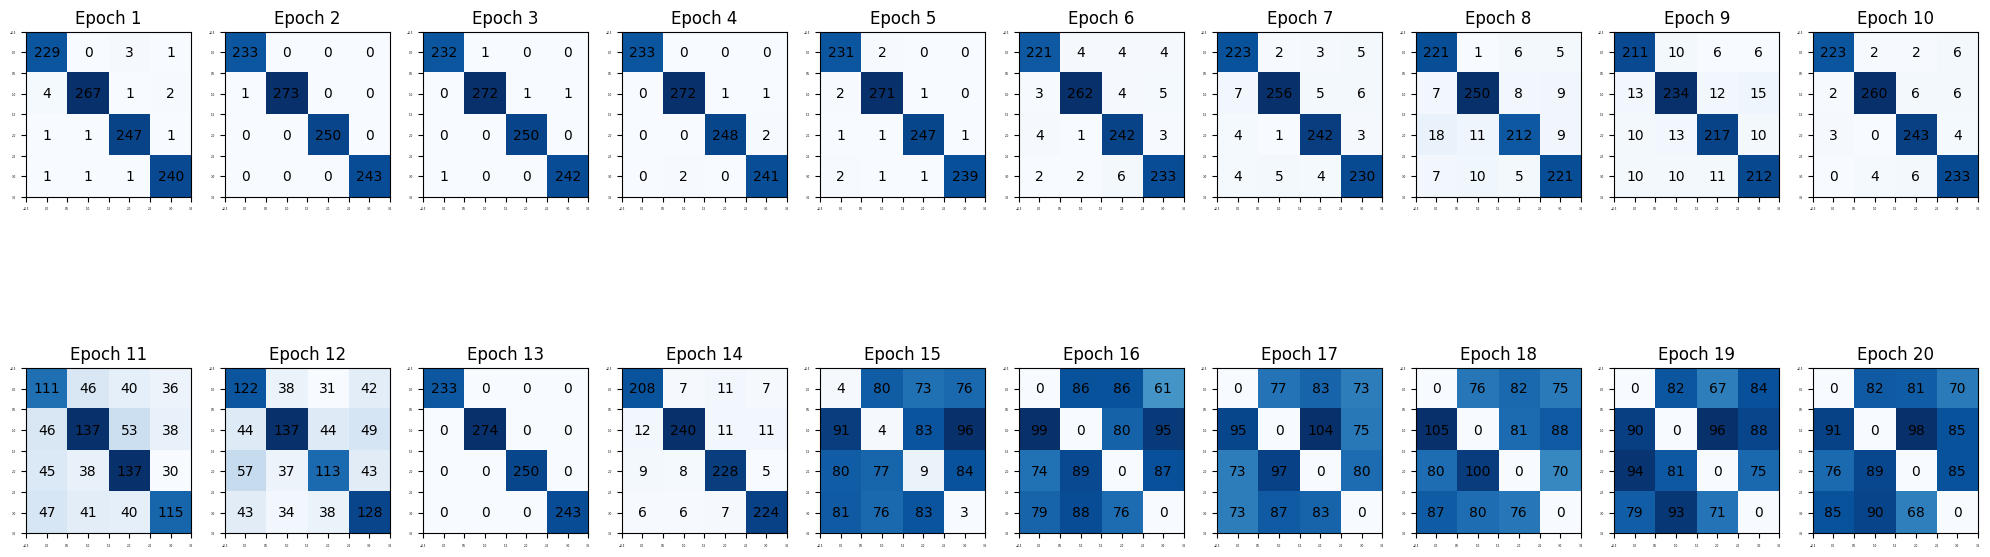

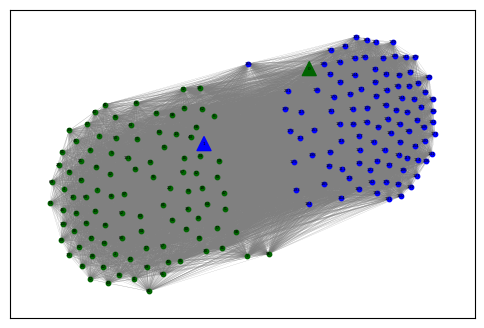

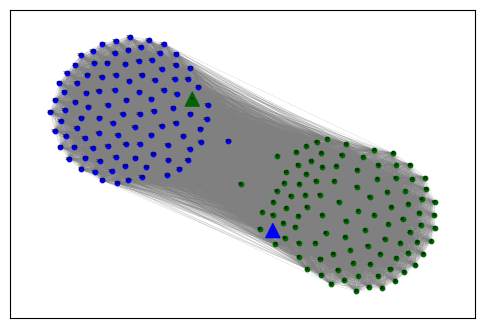

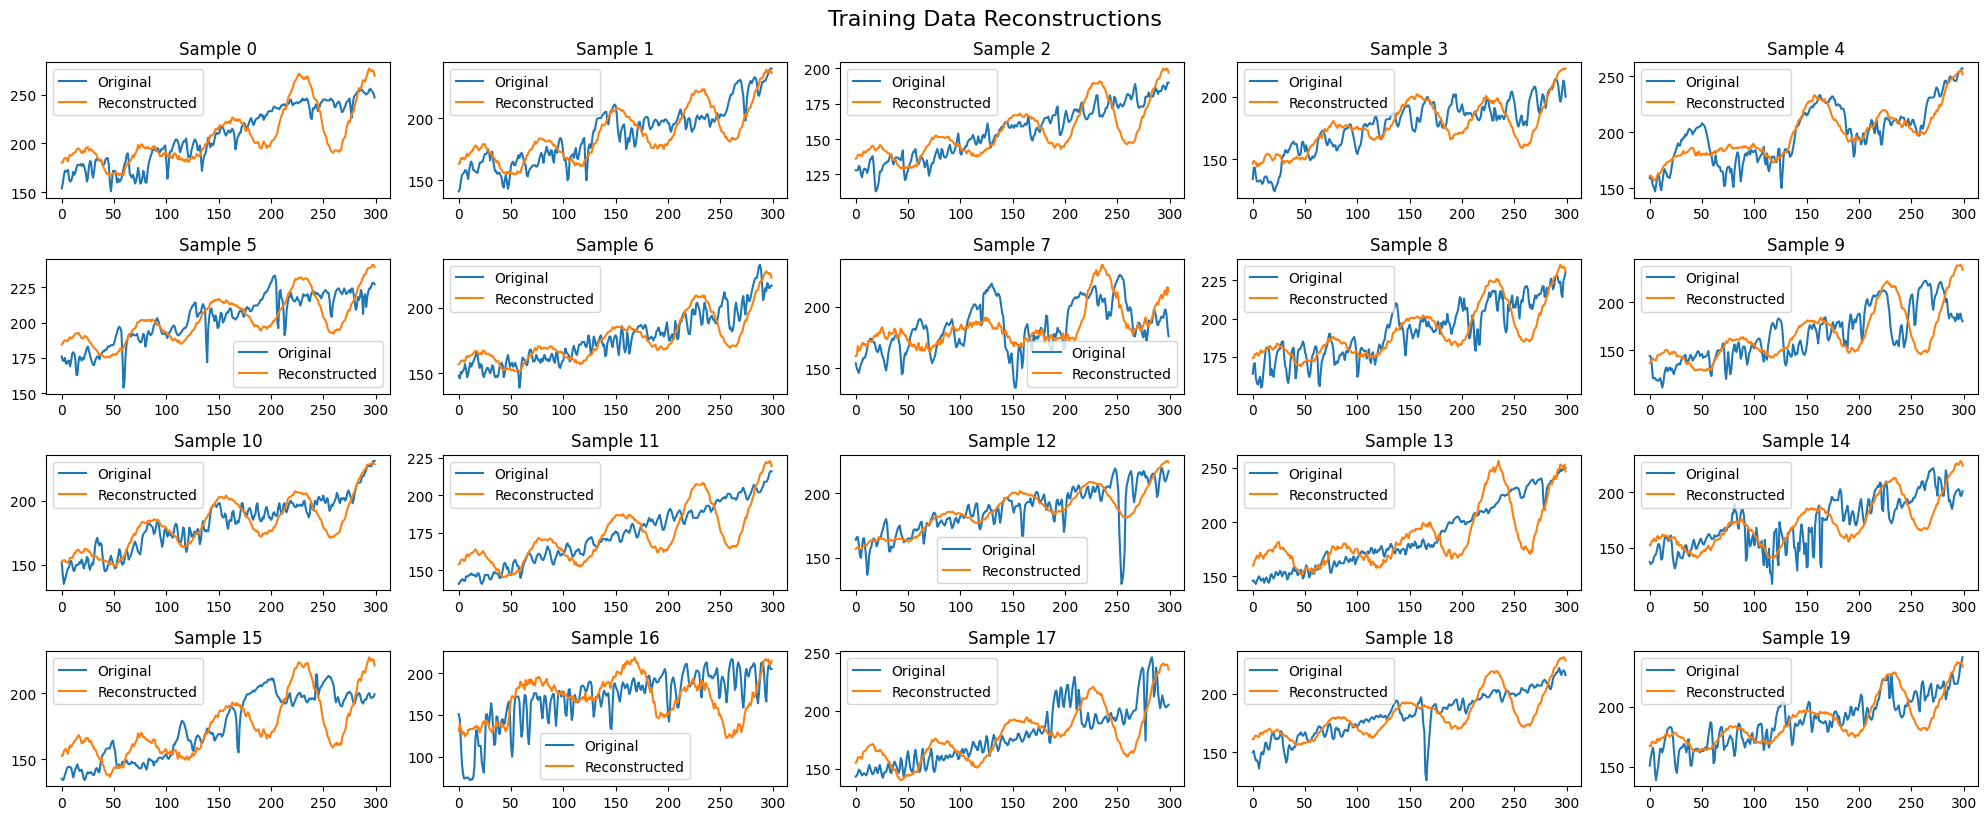

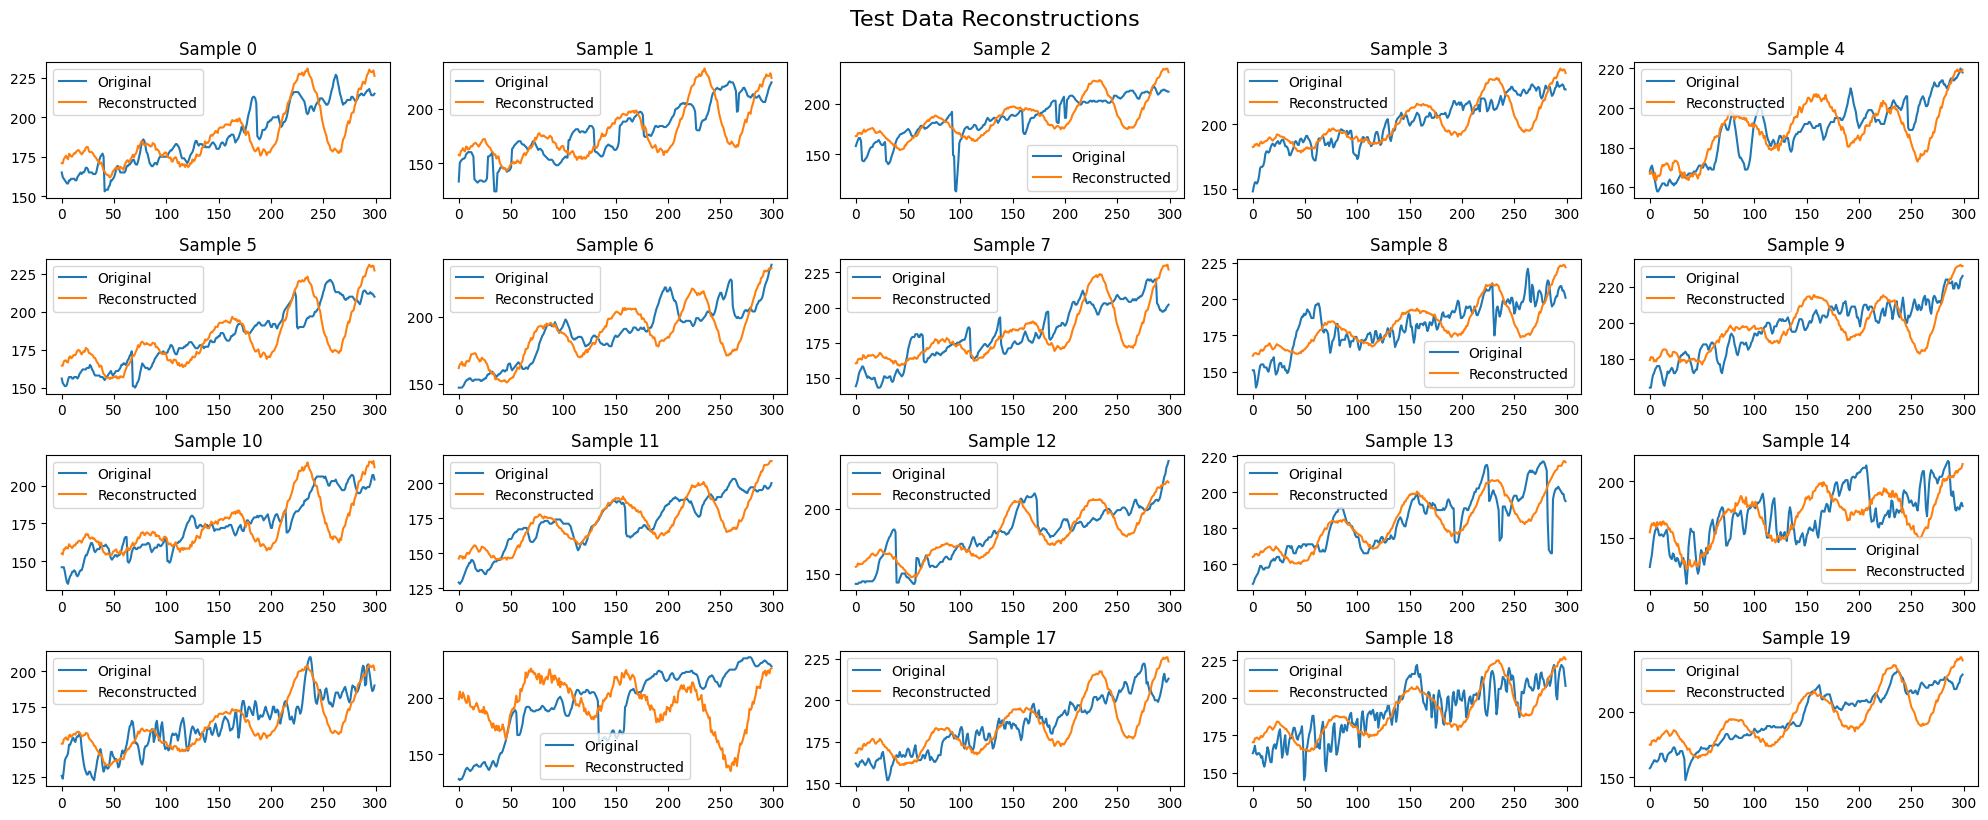

In [114]:

# overwrite = False
if overwrite or not os.path.exists(model_path):
    model.clip_mu = False

    # ------------------------- ready training for clip -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=500,      
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=0.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more

    
    for i in range(10):  # config_dict['num_saves']
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs']*50, 
                                                        target_type = 'by_target',
                                                        train_type='joint',
                                                        alpha = 1/10)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')
    
        # print results 
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
        pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
        
        # eval vae
        plot_reconstructions(model, 
                            df=df_train, 
                            config_dict = config_dict, 
                            text_col_ls = config_dict['text_col_ls'],
                            title="Training Data Reconstructions")

        plot_reconstructions(model, 
                            df=df_test, 
                            config_dict = config_dict, 
                            text_col_ls = config_dict['text_col_ls'],
                            title="Test Data Reconstructions")
        # distances = [0, 0.1, 0.25, 0.3, 0.6]
#         plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
#         plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    
        
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    
    # eval clip
    eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
    eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
    pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
    
    # eval vae
    plot_reconstructions(model, 
                        df=df_train, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Training Data Reconstructions")

    plot_reconstructions(model, 
                        df=df_test, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Test Data Reconstructions")
    # distances = [0, 0.1, 0.25, 0.3, 0.6]
    # plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    # plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    

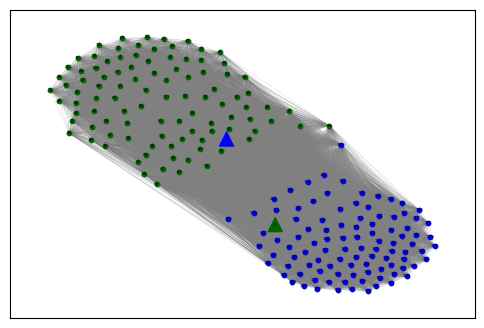

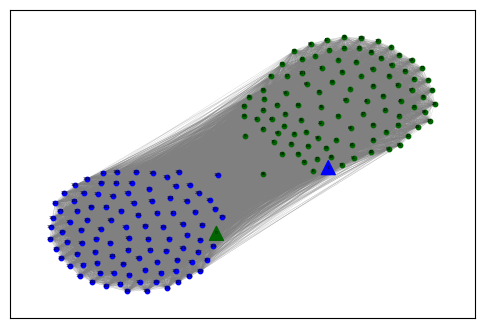

tensor(0.3783, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.3476, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4122, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.4511, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4003, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.3947, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.3797, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.4957, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.3882, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.4704, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.5965, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.3989, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.5945, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4088, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.6061, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.3984, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.4906, device='cuda:0', grad_fn=<SelectBackward0

In [9]:
pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
for i in range(95, 105):
    print(ts2tx_distances['simi']['High amount of consecutive increases.'][i])
    print(ts2tx_distances['simi']['Low amount of consecutive increases.'][i])

In [90]:
import torch
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


df = df_train.iloc[[0],:].copy()
print(df)

ts_f, tx_f, _ = get_features(df, config_dict, text_col = 'text1') # text1/text is the truth for this df
ts_f = ts_f.to(device)
tx_f = tx_f.to(device)
ts_emb, ts_emb_mean, ts_emb_log_var, x_mean, x_std = model.ts_encoder(ts_f)
tx_emb1 = model.text_encoder(tx_f)
# print(tx_emb1)
logit1 = model.clip(ts_emb_mean, tx_emb1)
print(logit1) # cosine similarity [-1,1]

ts_f, tx_f, _ = get_features(df, config_dict, text_col = 'text2')
ts_f = ts_f.to(device)
tx_f = tx_f.to(device)
ts_emb, ts_emb_mean, ts_emb_log_var, x_mean, x_std = model.ts_encoder(ts_f)
tx_emb2 = model.text_encoder(tx_f)
# print(tx_emb2)
logit2 = model.clip(ts_emb_mean, tx_emb2)
print(logit2) # cosine similarity [-1,1]

model.clip(tx_emb1, tx_emb2)

# plt.imshow(target_train[1000:1100, 1000:1100].cpu().numpy())

       VitalID  VitalTime    1    2    3    4    5    6    7    8  ...  \
24602     1918    4546134  154  159  167  172  171  172  173  164  ...   

                                          ts_description  \
24602  Higher than the normal range. High variability...   

                                        text  rowid  label  cluster  true1  \
24602  High amount of consecutive increases.  24602  24602     3746      1   

                                       text1  true2  \
24602  High amount of consecutive increases.      0   

                                      text2  \
24602  Low amount of consecutive increases.   

                                  text_oppo  
24602  Low amount of consecutive increases.  

[1 rows x 336 columns]
tensor([[-0.9454]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[0.9105]], device='cuda:0', grad_fn=<MmBackward0>)


tensor([[-0.7995]], device='cuda:0', grad_fn=<MmBackward0>)

tensor([[-0.9454]], device='cuda:0', grad_fn=<MmBackward0>)


In [21]:
logits = torch.cat([logit1, logit2], dim=1) # correctly predicted
targets = torch.tensor([[1,0]], device=device)
loss_ts = cross_entropy(logits, targets)
loss_tx = cross_entropy(logits.T, targets.T)
print(loss_ts)
print(loss_tx)
clip_loss = (loss_ts + loss_tx) / 2 # larger loss
print(clip_loss)

# print(targets)
# batch_size = logits.shape[0]
# print(logits)
# exp_preds = torch.exp(logits)
# print(exp_preds)
# softmax_probs = exp_preds / exp_preds.sum(dim=1, keepdim=True) # sum over the columns, keep the rows
# print(softmax_probs)
# log_probs = torch.log(softmax_probs + 1e-16)
# print(log_probs)
# loss = -torch.sum(targets * log_probs) / batch_size
# print(loss)

tensor(2.0012, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0., device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0006, device='cuda:0', grad_fn=<DivBackward0>)


In [22]:
logits = torch.cat([logit2, logit1], dim=1) # wrongly predicted
targets = torch.tensor([[1,0]], device=device)
loss_ts = cross_entropy(logits, targets)
loss_tx = cross_entropy(logits.T, targets.T)
print(loss_ts)
print(loss_tx)
clip_loss = (loss_ts + loss_tx) / 2
print(clip_loss)

# print(targets)
# batch_size = logits.shape[0]
# print(logits)
# exp_preds = torch.exp(logits)
# print(exp_preds)
# softmax_probs = exp_preds / exp_preds.sum(dim=1, keepdim=True) # sum over the columns, keep the rows
# print(softmax_probs)
# log_probs = torch.log(softmax_probs + 1e-16)
# print(log_probs)
# loss = -torch.sum(targets * log_probs) / batch_size
# print(loss)

tensor(0.1452, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0., device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0726, device='cuda:0', grad_fn=<DivBackward0>)


In [85]:
# Create opposite text column by swapping High and Low
df_train['text_oppo'] = df_train['text'].apply(
    lambda x: 'Low amount of consecutive increases.' if x == 'High amount of consecutive increases.' 
    else 'High amount of consecutive increases.' if x == 'Low amount of consecutive increases.'
    else x
)

print(df_train[['text', 'text_oppo']])
ts_f_train_oppo, tx_f_train_oppo, labels_train_oppo = get_features(df_train, config_dict, text_col = 'text_oppo')
train_dataloader_oppo = VITALDataset(ts_f_train_oppo, tx_f_train_oppo, labels_train_oppo, target_train).dataloader(batch_size=config_dict['batch_size'])


# ts_f_train_oppo, tx_f_train_oppo, labels_train_oppo = get_features(df_train, config_dict, text_col = 'text2')
# train_dataloader_oppo = VITALDataset(ts_f_train_oppo, tx_f_train_oppo, labels_train_oppo, target_train).dataloader(batch_size=config_dict['batch_size'])

                                        text  \
24602  High amount of consecutive increases.   
38743  High amount of consecutive increases.   
7130   High amount of consecutive increases.   
50561  High amount of consecutive increases.   
1840   High amount of consecutive increases.   
...                                      ...   
40522   Low amount of consecutive increases.   
32080   Low amount of consecutive increases.   
5927    Low amount of consecutive increases.   
9278    Low amount of consecutive increases.   
19251   Low amount of consecutive increases.   

                                   text_oppo  
24602   Low amount of consecutive increases.  
38743   Low amount of consecutive increases.  
7130    Low amount of consecutive increases.  
50561   Low amount of consecutive increases.  
1840    Low amount of consecutive increases.  
...                                      ...  
40522  High amount of consecutive increases.  
32080  High amount of consecutive increases.  


tensor([1088, 6569, 2527, 6393, 6886, 2885, 7574, 8759, 7723, 7920, 8244, 9756,
        6446, 1324, 8935, 7171, 5071, 8717, 9504, 9817, 4906, 8788, 7533, 4867,
        6784, 5436,  347, 7639, 8979, 9377, 3566, 5353, 9415, 2798, 6707, 2587,
        1104, 3244, 3920, 4878, 1641, 3151, 9176, 9753, 2130, 8857, 5305, 6054,
        6641, 5475, 1259, 8786, 9521, 6753,  919, 4746, 1707, 4095, 1958, 1254,
        1800, 4796, 9929, 5723, 9102, 5686, 6958, 2273, 4954, 9156, 2952, 6221,
        5893, 5260,  478, 7803, 5337, 2800, 8773, 1433, 7772, 1749, 7050, 1832,
        6599, 9526,   12, 9403, 1567, 8432, 8173, 8139, 4600, 2117, 4883, 3573,
        6822, 5937, 2110, 3890, 3319, 4073, 3698, 9217, 7312, 4907, 2344, 2692,
        1898,  783, 2863, 1374, 3027, 2996, 3367, 6556, 6995, 9044, 2713, 1878,
        5524, 2456, 4468, 7391, 5528, 7488, 9105, 7278, 2649, 4270, 5619, 6889,
        9731, 2385, 7568,  552, 7529, 4705, 8878,  323, 3276, 8868, 2086, 1376,
        5570, 6917, 5509, 4887, 4542, 77

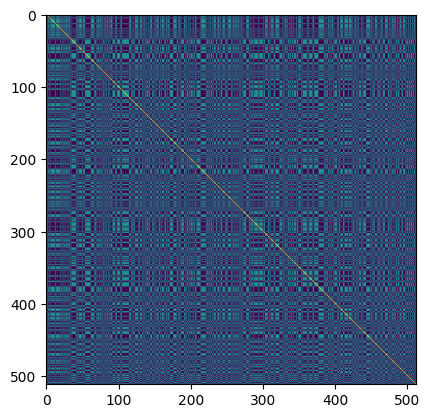

tensor([[-0.9075,  0.8994, -0.9075,  ...,  0.8994,  0.8994, -0.9075],
        [ 0.9627, -0.9499,  0.9627,  ..., -0.9499, -0.9499,  0.9627],
        [-0.9872,  0.9734, -0.9872,  ...,  0.9734,  0.9734, -0.9872],
        ...,
        [ 0.9213, -0.8312,  0.9213,  ..., -0.8312, -0.8312,  0.9213],
        [ 0.9207, -0.8122,  0.9207,  ..., -0.8122, -0.8122,  0.9207],
        [-0.9426,  1.0080, -0.9426,  ...,  1.0080,  1.0080, -0.9426]],
       device='cuda:0')


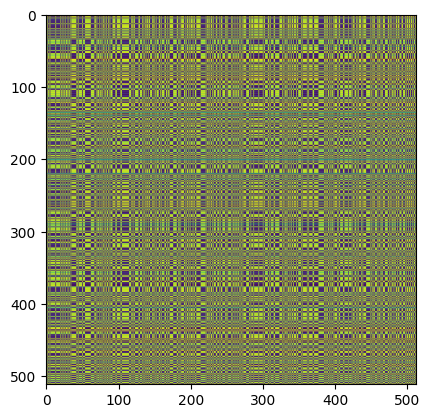

In [115]:
import torch
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)



model.eval()
total_loss = 0
num_batches = 0

with torch.no_grad():
    for _, (idx, ts, text_features, labels, targets) in enumerate(train_dataloader_oppo):
        print(idx)
        targets = targets[:,idx]
        logits, ts_hat, mean, log_var = model(ts, text_features)
        loss = compute_clip_loss(logits, labels, targets, target_type = "by_target")
        total_loss += loss.item()
        num_batches += 1
        break
    clip_loss = total_loss / num_batches

print(targets)
plt.imshow(targets.cpu().numpy())
plt.show()
print(logits)
plt.imshow(logits.cpu().numpy())
plt.show()

0
loss_ts: 732.8739624023438
loss_tx: 732.8739624023438
tensor([[1.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.5000],
        [0.0000, 1.0000, 0.0000,  ..., 0.5000, 0.5000, 0.0000],
        [0.5000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.5000],
        ...,
        [0.0000, 0.5000, 0.0000,  ..., 1.0000, 0.5000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.5000, 1.0000, 0.0000],
        [0.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 1.0000]],
       device='cuda:0')


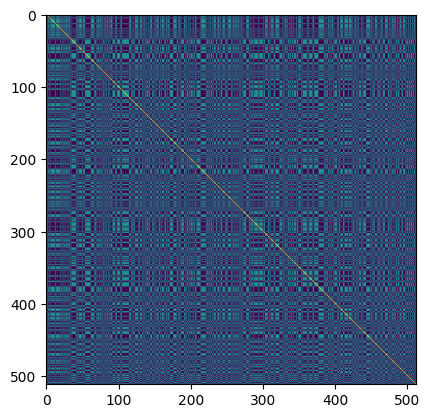

tensor([[ 0.8993, -0.9077,  0.8993,  ..., -0.9077, -0.9077,  0.8993],
        [-0.9499,  0.9628, -0.9499,  ...,  0.9628,  0.9628, -0.9499],
        [ 0.9734, -0.9873,  0.9734,  ..., -0.9873, -0.9873,  0.9734],
        ...,
        [-0.8312,  0.9213, -0.8312,  ...,  0.9213,  0.9213, -0.8312],
        [-0.8122,  0.9208, -0.8122,  ...,  0.9208,  0.9208, -0.8122],
        [ 1.0080, -0.9426,  1.0080,  ..., -0.9426, -0.9426,  1.0080]],
       device='cuda:0')


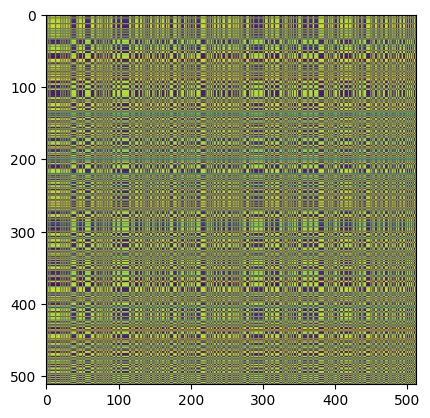

In [159]:
import torch
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


model.eval()
total_loss = 0
num_batches = 0

with torch.no_grad():
    for bid, (idx, ts, text_features, labels, targets) in enumerate(train_dataloader):
        print(bid)
        # print(idx)
        targets = targets[:,idx]
        logits, ts_hat, mean, log_var = model(ts, text_features)
        loss = compute_clip_loss(logits, labels, targets, target_type = "by_target")
        total_loss += loss.item()
        num_batches += 1
        break
    clip_loss = total_loss / num_batches

print(targets)
plt.imshow(targets.cpu().numpy())
plt.show()
print(logits)
plt.imshow(logits.cpu().numpy())
plt.show()

In [161]:
ts[0] # same as ts_f
text_features[0] # same as tx_f
targets[0][0]
logits[0][0]


tensor(0.8993, device='cuda:0')

In [185]:
z, mean, log_var, x_mean, x_std = model.ts_encoder(ts) # ts in raw scale
mean[0]
text_embedded = model.text_encoder(text_features[0].reshape(1,-1))
text_embedded[0]

tensor([ 1.2367e-03,  1.5237e-03,  1.6185e-03, -1.2342e-03,  2.1253e-01,
        -9.2856e-05,  1.8786e-03, -3.8853e-03, -2.6097e-03, -2.1794e-03,
        -1.3581e-04,  4.6024e-03,  2.8143e-03,  3.7643e-03, -1.5468e-04,
         4.4252e-03, -1.0226e-03, -3.4781e-03,  3.1759e-03,  7.9019e-04,
         2.1013e-03, -2.7109e-03, -1.9767e-03,  3.9611e-04,  2.6227e-03,
        -1.5158e-03, -2.1734e-03, -4.5863e-04, -5.1478e-03, -8.5502e-04,
        -1.6861e-03,  2.4820e-04, -1.2162e-03, -1.4152e-03,  1.2560e-03,
         1.1187e-03, -1.4617e-03,  1.3111e-03, -7.1200e-04, -1.9060e-03,
        -1.7006e-03, -1.9725e-03,  1.4691e-03,  8.9902e-02, -3.2667e-03,
        -1.0427e-03, -2.3138e-04,  1.9758e-03, -5.5348e-04, -2.2667e-03,
        -8.6955e-02, -1.8468e-03,  5.0393e-01, -2.8090e-03, -2.7915e-03,
        -5.5356e-03,  7.6970e-04,  5.9732e-03,  1.9498e-03,  3.2698e-04,
         1.7088e-03, -3.3473e-01,  1.7563e-03,  1.6335e-03, -4.3207e-04,
        -2.7100e-03, -4.6641e-03,  1.7356e-03, -6.6

In [187]:
text_embedded = model.text_encoder(text_features[0].reshape(1,-1))
print(text_embedded)

# wrong!!!
text_embedded = model.text_encoder(text_features)
print(text_embedded[0])


tensor([[ 1.2367e-03,  1.5237e-03,  1.6185e-03, -1.2342e-03,  2.1253e-01,
         -9.2856e-05,  1.8786e-03, -3.8853e-03, -2.6097e-03, -2.1794e-03,
         -1.3581e-04,  4.6024e-03,  2.8143e-03,  3.7643e-03, -1.5468e-04,
          4.4252e-03, -1.0226e-03, -3.4781e-03,  3.1759e-03,  7.9019e-04,
          2.1013e-03, -2.7109e-03, -1.9767e-03,  3.9611e-04,  2.6227e-03,
         -1.5158e-03, -2.1734e-03, -4.5863e-04, -5.1478e-03, -8.5502e-04,
         -1.6861e-03,  2.4820e-04, -1.2162e-03, -1.4152e-03,  1.2560e-03,
          1.1187e-03, -1.4617e-03,  1.3111e-03, -7.1200e-04, -1.9060e-03,
         -1.7006e-03, -1.9725e-03,  1.4691e-03,  8.9902e-02, -3.2667e-03,
         -1.0427e-03, -2.3138e-04,  1.9758e-03, -5.5348e-04, -2.2667e-03,
         -8.6955e-02, -1.8468e-03,  5.0393e-01, -2.8090e-03, -2.7915e-03,
         -5.5356e-03,  7.6970e-04,  5.9732e-03,  1.9498e-03,  3.2698e-04,
          1.7088e-03, -3.3473e-01,  1.7563e-03,  1.6335e-03, -4.3207e-04,
         -2.7100e-03, -4.6641e-03,  1.

In [180]:
model.eval()
df = df_train.iloc[[1088],:].copy()
with torch.no_grad():
    ts_f, tx_f, _ = get_features(df, config_dict, text_col = 'text') # text1/text is the truth for this df
    ts_f = ts_f.to(device)
    tx_f = tx_f.to(device)
    
    # # identical
    # plt.plot(ts_f[0].detach().cpu().numpy())
    # plt.show()
    # plt.plot(tx_f[0].detach().cpu().numpy())
    # plt.show()
    # plt.plot(ts[0].detach().cpu().numpy())
    # plt.show()
    # plt.plot(text_features[0].detach().cpu().numpy())
    # plt.show()

    logit0, ts_hat, mean, log_var = model(ts_f, tx_f)
logit0

tensor([[-0.8911]], device='cuda:0')

In [181]:
z, mean, log_var, x_mean, x_std = model.ts_encoder(ts_f)
mean[0]
text_embedded = model.text_encoder(tx_f)
text_embedded

tensor([[ 1.2367e-03,  1.5237e-03,  1.6185e-03, -1.2342e-03,  2.1253e-01,
         -9.2857e-05,  1.8786e-03, -3.8853e-03, -2.6097e-03, -2.1794e-03,
         -1.3581e-04,  4.6024e-03,  2.8143e-03,  3.7643e-03, -1.5468e-04,
          4.4252e-03, -1.0226e-03, -3.4781e-03,  3.1759e-03,  7.9019e-04,
          2.1013e-03, -2.7109e-03, -1.9767e-03,  3.9611e-04,  2.6227e-03,
         -1.5158e-03, -2.1734e-03, -4.5863e-04, -5.1478e-03, -8.5502e-04,
         -1.6861e-03,  2.4820e-04, -1.2162e-03, -1.4152e-03,  1.2560e-03,
          1.1187e-03, -1.4617e-03,  1.3111e-03, -7.1200e-04, -1.9060e-03,
         -1.7006e-03, -1.9725e-03,  1.4692e-03,  8.9902e-02, -3.2667e-03,
         -1.0427e-03, -2.3138e-04,  1.9758e-03, -5.5348e-04, -2.2667e-03,
         -8.6955e-02, -1.8468e-03,  5.0393e-01, -2.8090e-03, -2.7915e-03,
         -5.5356e-03,  7.6970e-04,  5.9732e-03,  1.9498e-03,  3.2698e-04,
          1.7088e-03, -3.3473e-01,  1.7563e-03,  1.6335e-03, -4.3207e-04,
         -2.7100e-03, -4.6641e-03,  1.

In [ ]:
# ---- VAE encoder ----
z, mean, log_var, x_mean, x_std = model.ts_encoder(ts) # ts in raw scale

# --- Text encoder forward pass ---
text_embedded = self.text_encoder(text_features)

# --- CLIP forward pass ---
if self.clip_mu:
    logits = self.clip(mean, text_embedded)
else:
    logits = self.clip(z, text_embedded)


In [130]:
ts_f
tx_f

ts_emb, ts_emb_mean, ts_emb_log_var, x_mean, x_std = model.ts_encoder(ts_f)
tx_emb1 = model.text_encoder(tx_f)
# print(tx_emb1)
logit1 = model.clip(ts_emb_mean, tx_emb1)
print(logit1) # cosine similarity [-1,1]


logits, ts_hat, mean, log_var = model(ts_f, tx_f)

tensor([[-0.9561]], device='cuda:0', grad_fn=<MmBackward0>)


In [123]:

ts_emb, ts_emb_mean, ts_emb_log_var, x_mean, x_std = model.ts_encoder(ts_f)
tx_emb1 = model.text_encoder(tx_f)
# print(tx_emb1)
logit1 = model.clip(ts_emb_mean, tx_emb1)
print(logit1) # cosine similarity [-1,1]


tensor([[-0.9381]], device='cuda:0', grad_fn=<MmBackward0>)


In [112]:
df = df_train.iloc[[1088],:].copy()

ts_f_train0, tx_f_train0, labels_train0 = get_features(df, config_dict, text_col = 'text1')
train_dataloader0 = VITALDataset(ts_f_train0, tx_f_train0, labels_train0,  torch.tensor([[1]], device=device)).dataloader(batch_size=config_dict['batch_size'])
import torch
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)



model.eval()
total_loss = 0
num_batches = 0

with torch.no_grad():
    for _, (idx, ts, text_features, labels, targets) in enumerate(train_dataloader0):
        targets = targets[:,idx]
        logits, ts_hat, mean, log_var = model(ts, text_features)
        loss = compute_clip_loss(logits, labels, targets, target_type = "by_target")
        total_loss += loss.item()
        num_batches += 1
        break
    clip_loss = total_loss / num_batches

print(targets)
print(logits)

loss_ts: -0.0
loss_tx: -0.0
tensor([[1.]], device='cuda:0')
tensor([[-0.9044]], device='cuda:0')


In [113]:
tx_f_train0

tensor([[0.5498, 0.6341, 0.5489, 0.6144, 0.6159, 0.5670, 0.3123, 0.6034, 0.5436,
         0.7373, 0.8989, 0.8668, 0.5554, 0.7885, 0.4906, 0.7092, 0.5745, 0.3467,
         0.4741, 0.5075, 0.4605, 0.4589, 0.5537, 0.3739, 0.4542, 0.4778, 0.7324,
         0.3727, 0.6073, 0.2473, 0.4686, 0.4390, 0.6088, 0.5607, 0.5549, 0.2377,
         0.6365, 0.5556, 0.3782, 0.7877, 0.4159, 0.4100, 0.6137, 0.5573, 0.6282,
         0.4823, 0.4165, 0.6600, 0.4684, 0.5037, 0.7152, 0.4739, 0.6188, 0.3890,
         0.8485, 0.3217, 0.5282, 0.6792, 0.5690, 0.6721, 0.5451, 0.4840, 0.6989,
         0.6058, 0.5849, 0.6075, 0.7575, 0.4748, 0.7622, 0.6085, 0.4250, 0.6506,
         0.6599, 0.6915, 0.5376, 0.4326, 0.5303, 0.3885, 0.4128, 0.3436, 0.7793,
         0.7865, 0.5493, 0.7265, 0.4709, 0.3176, 0.4817, 0.5072, 0.7665, 0.4760,
         0.5797, 0.4643, 0.5996, 0.6330, 0.3464, 0.5714, 0.6712, 0.4463, 0.7344,
         0.4779, 0.6487, 0.6784, 0.4875, 0.6439, 0.2577, 0.4468, 0.3369, 0.3820,
         0.4617, 0.8525, 0.5